In [117]:
# Import libraries
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Load teachers metadata
teachers = pd.read_csv('C:\\Users\LIPSITA_SENAPATI\Desktop\TEACHERS.csv', low_memory=False)


# Print the first three rows
teachers.head(3)

,Teacher,vote_average,vote_count,id,specialisation,sp
0,A,7.7,5415,862,c,1
1,B,6.9,2413,8844,python,2
2,C,6.5,92,15602,java,3


In [118]:
# Load ratings data
ratings = pd.read_csv(r'C:/Users/LIPSITA_SENAPATI/Documents/ratings.csv', low_memory=False)
max_teacher_id = ratings['id'].drop_duplicates().max()
max_specialisation_id = ratings['sp'].drop_duplicates().max()


# Print the first three rows
ratings.head(3)

,id,sp,vote_average
0,862,1,7.7
1,8844,2,6.9
2,15602,3,6.5


In [119]:
# Load specialisation metadata
specialisation = pd.read_csv('C:\\Users\LIPSITA_SENAPATI\Desktop\specialisation.csv', low_memory=False)


# Print the first three rows
specialisation.head(3)

,specialisation,sp
0,c,1
1,python,2
2,java,3


In [120]:
n_teachers = teachers.id.unique().shape[0]
n_specialisation = teachers.sp.unique().shape[0]
print ('Number of teachers = ' + str(n_teachers) + ' | Number of specialisation = ' + str(n_specialisation))

Number of teachers = 26 | Number of specialisation = 7


In [121]:
teachers.user_id = teachers.id.astype('category').cat.codes.values
teachers.item_id = teachers.sp.astype('category').cat.codes.values

In [122]:
teachers.head()

,Teacher,vote_average,vote_count,id,specialisation,sp
0,A,7.7,5415,862,c,1
1,B,6.9,2413,8844,python,2
2,C,6.5,92,15602,java,3
3,D,6.1,34,31357,c++,4
4,E,5.7,173,11862,c++,4


In [123]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(teachers, test_size=0.2)

In [124]:
train.head()

,Teacher,vote_average,vote_count,id,specialisation,sp
9,J,6.6,1194,710,scala,6
18,S,6.1,1128,9273,ruby,5
23,X,6.3,143,12665,c,1
20,U,6.4,305,8012,python,2
15,P,7.8,1343,524,c++,4


In [125]:
test.head()

,Teacher,vote_average,vote_count,id,specialisation,sp
0,A,7.7,5415,862,c,1
16,Q,7.2,364,4584,scala,6
13,N,7.1,72,10858,java,3
4,E,5.7,173,11862,c++,4
8,I,5.5,174,9091,ruby,5


In [126]:
import keras
from keras.layers import merge
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_teacher, n_specialisation = len(teachers.id.unique()), len(teachers.sp.unique())
n_latent_factors = 3

In [127]:
from keras.constraints import non_neg
specialisation_input = keras.layers.Input(shape=[1],name='Item')
specialisation_embedding = keras.layers.Embedding(n_specialisation + 1, n_latent_factors, name='NonNegSpecialisation-Embedding',embeddings_constraint=non_neg())(specialisation_input)
specialisation_vec = keras.layers.Flatten(name='FlattenMovies')(specialisation_embedding)

teacher_input = keras.layers.Input(shape=[1],name='teacher')
teacher_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_teacher + 1, n_latent_factors,name='NonNegTeacher-Embedding',embeddings_constraint=non_neg())(teacher_input))

prod = keras.layers.dot([specialisation_vec, teacher_vec], normalize=False,axes=1)
model = keras.Model([teacher_input, specialisation_input], prod)
model.compile('adam', 'mean_squared_error')

In [128]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
teacher (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
NonNegSpecialisation-Embedding  (None, 1, 3)         24          Item[0][0]                       
__________________________________________________________________________________________________
NonNegTeacher-Embedding (Embedd (None, 1, 3)         81          teacher[0][0]                    
__________________________________________________________________________________________________
FlattenMov

In [129]:
history=model.fit([train.id, train.sp], train.vote_average, epochs=100, verbose=0)

Text(0,0.5,'Train Error')

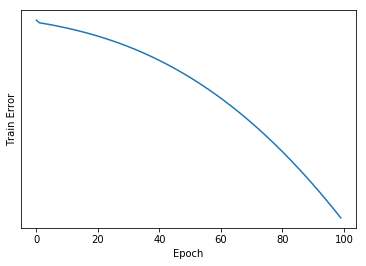

In [130]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [131]:
y_hat = np.round(model.predict([test.id, test.sp]),0)
y_true = test.vote_average

In [132]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

6.433333333333334

In [133]:
specialisation_embedding_learnt = model.get_layer(name='NonNegSpecialisation-Embedding').get_weights()[0]
pd.DataFrame(specialisation_embedding_learnt).describe()

,0,1,2
count,8.000000,8.000000,8.000000
mean,0.029126,0.029008,0.028681
std,0.057639,0.059133,0.054306
min,-0.000000,-0.000000,-0.000000
25%,-0.000000,-0.000000,-0.000000
50%,0.010255,0.001008,0.009460
75%,0.020776,0.021811,0.019190
max,0.170061,0.169824,0.159364


In [134]:
teacher_embedding_learnt = model.get_layer(name='NonNegTeacher-Embedding').get_weights()[0]
pd.DataFrame(teacher_embedding_learnt).describe()

,0,1,2
count,27.000000,27.000000,27.000000
mean,0.013453,0.017933,0.011961
std,0.025621,0.030309,0.032477
min,-0.000000,-0.000000,-0.000000
25%,-0.000000,-0.000000,-0.000000
50%,0.000000,0.003038,0.000000
75%,0.021007,0.028681,0.009563
max,0.122768,0.144579,0.167271
